# Analyzing Figure Skating Scores from 2016-2018

Mei-An Blatchford <br> UID: 115943339

In [94]:
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np 
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
sns.set(rc={"figure.figsize":(10, 6)})
sns.set_theme(style="whitegrid")
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as formula
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm

# Data Collection & Parsing

This dataset was created by BuzzFeedNews, they sourced the official data from 17 ISU (International Skating Union) competitions results that occured from October 2016-December 2017. Access the [dataset](https://github.com/BuzzFeedNews/figure-skating-scores/blob/master/data/tidy/performances.csv). 

In [95]:
url = 'https://github.com/BuzzFeedNews/figure-skating-scores/blob/master/data/tidy/performances.csv?raw=true'
df = pd.read_csv(url,index_col=0)

**Note about Figure Skating Programs:** <br>
Figure skating competitions comprise of two parts: a short program and a free skate (also know as long program), these program differ in duration and number of moves completed in their respective program. Skaters can earn points by doing specific moves, such as jumps or spins, at different levels. Most male figure skaters that compete at the international level usually perform moves at the highest level which is level 4 spins and quad (four rotations) jumps. You can read more about figure skating scoring [here.](https://www.usfigureskating.org/about/scoring-system)


In [96]:
#Here I am combining both the Senior Mens Short Program and Mens Free Skate and also marking when the competiton
#took place in the season column
season = []
comp_2016 = ['ISU GP 2016 Progressive Skate America', 'ISU GP 2016 Skate Canada International', 'ISU GP Rostelecom Cup 2016'\
            ,'ISU GP Trophee de France 2016', 'ISU GP Audi Cup of China 2016', 'ISU GP NHK Trophy 2016', 'ISU Grand Prix of Figure Skating Final 2016'\
            ,'ISU European Figure Skating Championships 2017', 'ISU Four Continents Championships 2017', 'ISU World Figure Skating Championships 2017']
comps = comp_2016 + ['ISU GP Rostelecom Cup 2017', 'ISU GP 2017 Skate Canada International', 'ISU GP Audi Cup of China 2017', \
                        'ISU GP NHK Trophy 2017', 'ISU GP Internationaux de France de Patinage 2017', 'ISU GP 2017 Bridgestone Skate America',\
                     'Grand Prix Final 2017 Senior and Junior']
comp_order = []
for index, row in df.iterrows():
    comp_order.append(comps.index(row['competition']))
    if row['competition'] in comp_2016:
        season.append('2016-2017 Season')
    else:
        season.append('2017-2018 Season')
df['season'] = season
df['comp_order'] = comp_order
mens_fs = df.loc[df['program'] == 'MEN FREE SKATING']
mens_sp = df.loc[df['program'] == 'MEN SHORT PROGRAM']
mens = pd.concat([mens_fs, mens_sp])
print(mens.head())

                                            competition           program  \
performance_id                                                              
0c18375356      Grand Prix Final 2017 Senior and Junior  MEN FREE SKATING   
08078dfa79      Grand Prix Final 2017 Senior and Junior  MEN FREE SKATING   
f5afc3d8ed      Grand Prix Final 2017 Senior and Junior  MEN FREE SKATING   
e5738bdb58      Grand Prix Final 2017 Senior and Junior  MEN FREE SKATING   
6fb9fe45c5      Grand Prix Final 2017 Senior and Junior  MEN FREE SKATING   

                           name nation  rank  starting_number  \
performance_id                                                  
0c18375356          Adam RIPPON    USA     5                1   
08078dfa79       Sergei VORONOV    RUS     4                2   
f5afc3d8ed          Jason BROWN    USA     6                3   
e5738bdb58          Nathan CHEN    USA     2                4   
6fb9fe45c5      Mikhail KOLYADA    RUS     3                5   

    

# Data Visualization

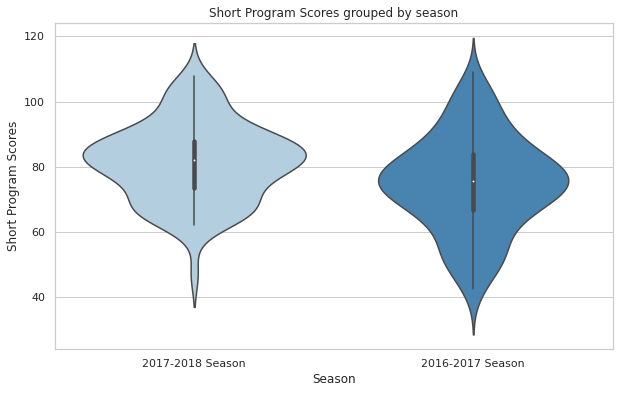

In [97]:
ax= sns.violinplot(x="season", y="total_segment_score", data=mens_sp, palette="Blues").set( \
                  title='Short Program Scores grouped by season', xlabel='Season', ylabel='Short Program Scores')
plt.show()

This dataset contains major ISU competitions from two seasons: the 2016-2017 season and 2017-2018 season. In this violinplot, I have plotted the distribution of short program scores grouped by the season. We can see a slight increase of the average in the 2017-2018 season compared to the 2016-2017 season. The range is also smaller in the 2017-2018 season.

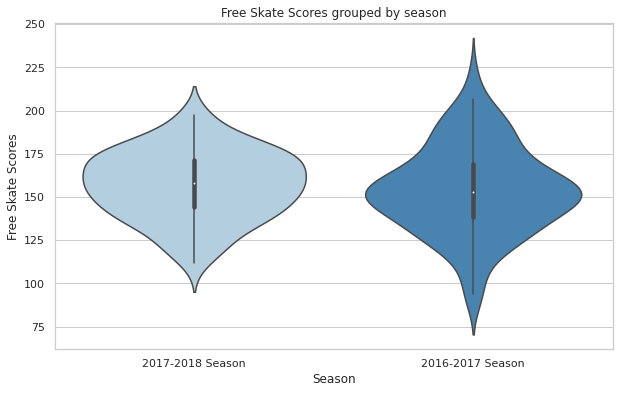

In [98]:
ax = sns.violinplot(x="season", y="total_segment_score", data=mens_fs, palette="Blues").set( \
                  title='Free Skate Scores grouped by season', xlabel='Season', ylabel='Free Skate Scores')
plt.show()

In this violinplot, I have plotted the Free Skate Scores grouped by season. The average is about the same for both seasons but in this chart, we can really see the difference between the range of scores. The 2016-2017 season has a much larger range, this may be because there were more competitons in the 2016-2017 season. 

In [99]:
mens_grouped = mens.drop(columns=['rank', 'starting_number']).\
            groupby(['name', 'competition','nation', 'comp_order']).sum()
mens_grouped = mens_grouped.sort_values(by=['total_segment_score'], ascending=False).reset_index()
#Here are the top scores from the 2016-2017 season & 2017-2018 season combined
mens_grouped = mens_grouped.loc[mens_grouped['total_segment_score'] >= 200]
print(mens_grouped.head())

           name                                  competition nation  \
0  Yuzuru HANYU  ISU World Figure Skating Championships 2017    JPN   
1     Shoma UNO  ISU World Figure Skating Championships 2017    JPN   
2   Nathan CHEN       ISU Four Continents Championships 2017    USA   
3  Yuzuru HANYU       ISU Four Continents Championships 2017    JPN   
4    Boyang JIN  ISU World Figure Skating Championships 2017    CHN   

   comp_order  total_segment_score  total_element_score  \
0           9               321.59               178.16   
1           9               319.31               179.19   
2           8               307.46               175.06   
3           8               303.71               162.44   
4           9               303.58               176.59   

   total_component_score  total_deductions  
0                 144.43               1.0  
1                 140.12               0.0  
2                 132.40               0.0  
3                 141.27              

I filtered the combined scores by scores that were over 200 to eliminate some countries that are less likely to medal. Ideally, a male figure skater must score at least 300 points to to place on the podium. In this project, I want to mainly focus on the top figure skaters since they are more likely to compete in competitions and have more scores officially recorded. In this dataframe, we can see the skater, the competiton they competed at and the scores that they earned.   

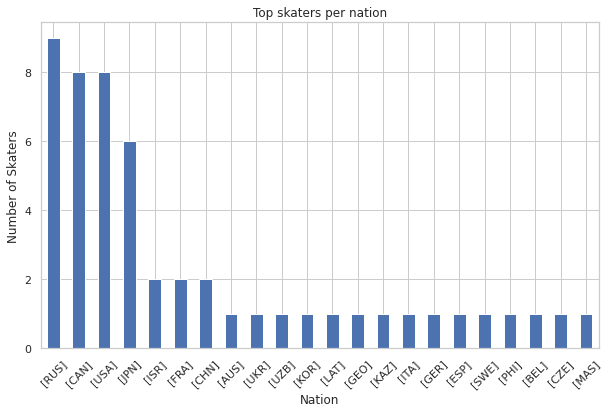

In [100]:
unique_men = mens_grouped.groupby('name')['nation'].unique().reset_index()
skaters_per_country = unique_men['nation'].value_counts()
skaters_per_country.plot.bar(rot=0).set(title='Top skaters per nation', \
                            xlabel='Nation', ylabel='Number of Skaters')
plt.xticks(rotation=45)
plt.show()

From the bar chart above, we can see, Russia, Canada, United States and Japan have the most skaters that are consistently scoring over 200 points in competition with Russia having nine different skaters scoring over 200. <br>
Note: One of the US top skater, Nathan Chen, is currently studying statistics and data science at Yale. [Check it out!](https://olympics.nbcsports.com/2021/01/13/nathan-chen-dick-button-figure-skating/)

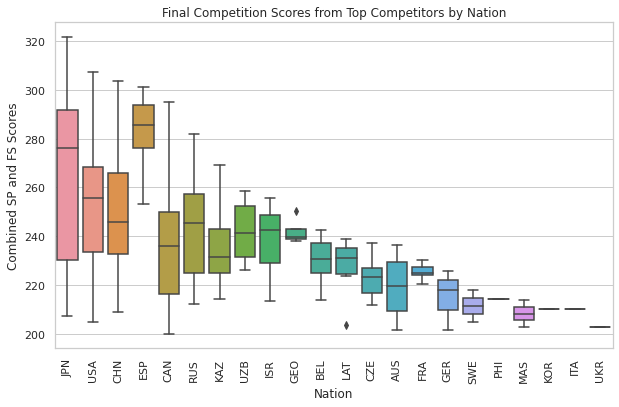

In [101]:
tss_final = sns.boxplot(x='nation', y='total_segment_score', data=mens_grouped).set(\
                            title='Final Competition Scores from Top Competitors by Nation', \
                            xlabel='Nation', ylabel='Combined SP and FS Scores')
plt.xticks(rotation=90)
plt.show()

From this boxplot, we can see the distribution of the scores that were over 200 total points over the 17 competitions grouped by nation. These scores are the combination of the short program and free skate, the final score that is used for final ranking for competiton. From the graph, we can see that that Spain has a highest average total points but the range is very small. From our bar chart, we know that Spain only has one skater that scores over 200 points in competition, so this one skater has a high average and a small range. Comparatively, Japan has a lower, but still high, average and a large range. Japan has six skaters to account for, so these skaters usually score high and one skater who earned the highest score from all the competitions. 


# Predicting Competition Scores Based on Duration of the Season

For this part, I want to see if there is a linear relationship between when a competiton took place in the season and the scores earned by the skater. For this part, I decided to use skaters who earned a rank greater or equal to 5 in competitions that were in the 2016-2017 season. Only the top 3 medal in events, although some competitions have a pewter medal for fourth place, but I wanted to have a larger dataset. I also chose to focus on competitions from the 2016-2017 season since skaters will be performing the same program throughout the season. 

**Null Hypothesis:** Scores of either the short and free program of top Men figure skaters do not improve over the season.

In [102]:
top_competitors = mens.loc[mens['rank']<= 5] #Filtering my dataset to hold only infromation for people who rank above 5
top_competitors =  top_competitors.loc[top_competitors['season'] == '2016-2017 Season']
unique_men = top_competitors['name'].unique() #Contains the name of the people we are going to evaluate 

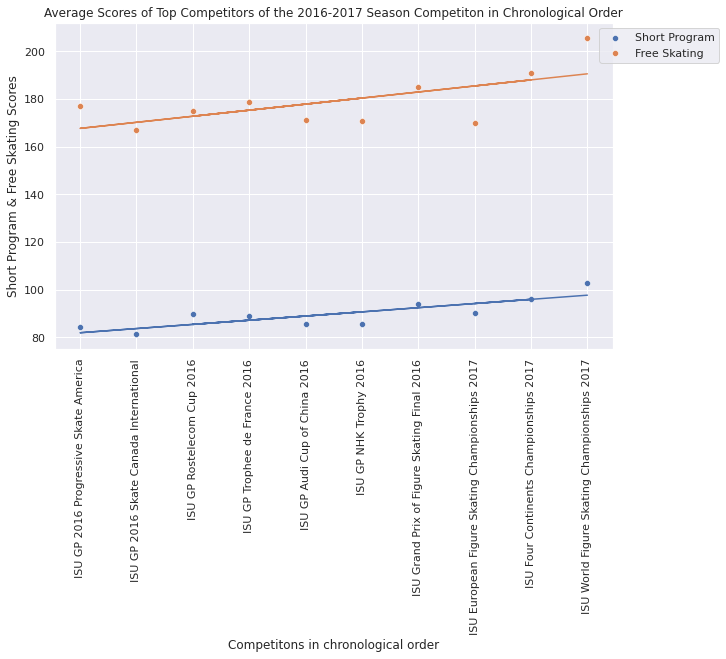

In [103]:
#I made a scatter plot of competition order vs Short & Long scores respectively and added a regression line using the
#average scores from the respective competiton 
sns.set(rc={"figure.figsize":(10, 6)})
comp_avg = top_competitors.loc[top_competitors['season'] == '2016-2017 Season']
comp_avg = comp_avg.groupby(['competition','program','comp_order', 'season'], as_index = False).mean()
fig, ax = plt.subplots()

ax = sns.scatterplot(data=comp_avg.loc[comp_avg['program'] == 'MEN SHORT PROGRAM'], x="comp_order", \
                 y="total_segment_score", label = "Short Program").set(\
                 title='Average Scores of Top Competitors of the 2016-2017 Season Competiton in Chronological Order', \
                 xlabel='Competitons in chronological order', \
                 ylabel='Short Program & Free Skating Scores', xticks= range(len(comp_2016)), xticklabels = comp_2016)
ax = sns.scatterplot(data=comp_avg.loc[comp_avg['program'] == 'MEN FREE SKATING'], x="comp_order", \
                 y="total_segment_score", label = "Free Skating")

sp_avg = comp_avg.loc[comp_avg['program'] == 'MEN SHORT PROGRAM']
z = np.polyfit(sp_avg['comp_order'], sp_avg['total_segment_score'] , 1)
p = np.poly1d(z)
ax.plot(sp_avg['comp_order'], p(sp_avg['comp_order']))

fs_avg = comp_avg.loc[comp_avg['program'] == 'MEN FREE SKATING']
z = np.polyfit(fs_avg['comp_order'], fs_avg['total_segment_score'] , 1)
p = np.poly1d(z)
ax.plot(fs_avg['comp_order'], p(fs_avg['comp_order']))
ax.set_xticks(range(len(comp_2016)))
ax.set_xticklabels(comp_2016)

plt.legend( bbox_to_anchor=(1.2, 1))
plt.xticks(rotation=90)
plt.show()

I plotted the average scores of each respective programs for the competitions in chronological order. Using the line of best fit, we can see a general increase of both the short program and free skate scores over the 2016-2017 season for top competitors as the season continues.  The scores at the 2017 World Figure Skating Championships are much higher than the scores at other competitons. This may be because there are more skaters that are trying harder in order to win a prestigious title. 

In [104]:
#Getting short program scores from the top competitors
top_sp = top_competitors.loc[top_competitors['program'] == 'MEN SHORT PROGRAM']

Y = top_sp['total_segment_score']
X = top_sp['comp_order']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())
slope = results.params[1]
intercept = results.params[0]
rsquared = results.rsquared
print('Slope of linear regression: %f' %slope)
print('Intercept of linear regression: %f' %intercept)
print('RSquared of linear regression:', rsquared)

                             OLS Regression Results                            
Dep. Variable:     total_segment_score   R-squared:                       0.324
Model:                             OLS   Adj. R-squared:                  0.310
Method:                  Least Squares   F-statistic:                     23.00
Date:                 Mon, 20 Dec 2021   Prob (F-statistic):           1.61e-05
Time:                         17:03:45   Log-Likelihood:                -170.13
No. Observations:                   50   AIC:                             344.3
Df Residuals:                       48   BIC:                             348.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         81.8999      1.950     41.99

Using the [OLS linear regression model](https://towardsdatascience.com/understanding-the-ols-method-for-simple-linear-regression-e0a4e8f692cc), we would except to see a 1.75 point increase on average in the short program scores as the figure skating season continues. We would reject the null hypothesis since the p-value is 0, we would state that there is a correlation between the competition order and scores, as the season continues scores of the free skating program increase. However, our R2 value is low, which means this model can not account for 30% of the variance occurred. 

<ipython-input-105-72eb5f10b353>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_sp['intercept_res'] = intercept_res


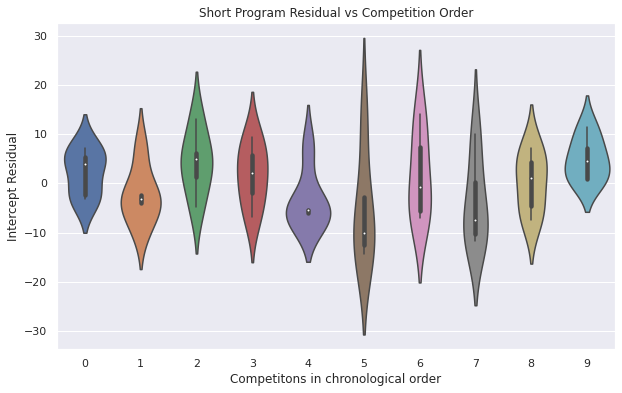

In [105]:
intercept_res = []
for index, row in top_sp.iterrows():
    intercept_res.append(row['total_segment_score'] - (row['comp_order']*slope + intercept))

top_sp['intercept_res'] = intercept_res
ax = sns.violinplot(x='comp_order', y='intercept_res', data=top_sp)
ax.set_title("Short Program Residual vs Competition Order")
ax.set_ylabel("Intercept Residual")
ax.set_xlabel("Competitons in chronological order")
plt.show()

From the graph above, we can see that the residual is mostly centered around zero but some competitions, mainly 6,8, and 9 are above average. The data is not very uniform, especially in competiton 1 and 4, we can see most of the data is skewed to the right. We can see the variance that was shown in our R2 value displayed in this residual graph.

In [109]:
#Getting free skating scores from the top competitors
top_fs = top_competitors.loc[top_competitors['program'] == 'MEN FREE SKATING']

Y = top_fs['total_segment_score']
X = top_fs['comp_order']
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())
slope = results.params[1]
intercept = results.params[0]
rsquared = results.rsquared
print('Slope of linear regression: %f' %slope)
print('Intercept of linear regression: %f' %intercept)
print('RSquared of linear regression:', rsquared)

                             OLS Regression Results                            
Dep. Variable:     total_segment_score   R-squared:                       0.186
Model:                             OLS   Adj. R-squared:                  0.169
Method:                  Least Squares   F-statistic:                     10.99
Date:                 Mon, 20 Dec 2021   Prob (F-statistic):            0.00175
Time:                         17:04:08   Log-Likelihood:                -207.26
No. Observations:                   50   AIC:                             418.5
Df Residuals:                       48   BIC:                             422.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        167.6898      4.098     40.91

Using the [OLS linear regression model](https://towardsdatascience.com/understanding-the-ols-method-for-simple-linear-regression-e0a4e8f692cc), we would except to see a 2.544 point increase on average in the free skating program scores as the figure skating season continues. We would reject the null hypothesis since our p value is below 0.005 and state that there is a correlation between the competition order and scores, as the season continues scores of the free skating program increase. However, our R2 value is low, which means this model does not explain the variance in the model. This may be because our model is not correct. 

<ipython-input-110-cd99986e403e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_fs['intercept_res'] = intercept_res


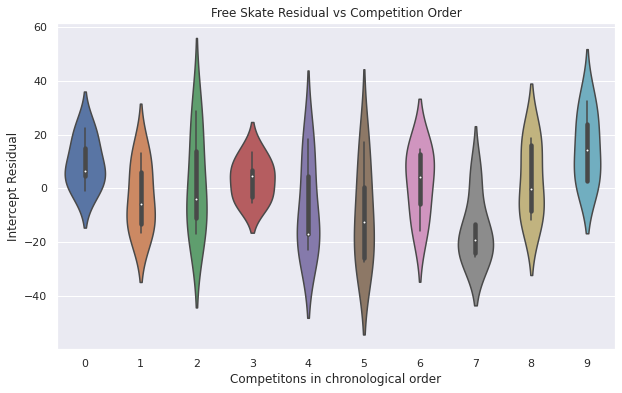

In [110]:
intercept_res = []
for index, row in top_fs.iterrows():
    intercept_res.append(row['total_segment_score'] - (row['comp_order']*slope + intercept))

top_fs['intercept_res'] = intercept_res
ax = sns.violinplot(x='comp_order', y='intercept_res', data=top_fs)
ax.set_title("Free Skate Residual vs Competition Order")
ax.set_ylabel("Intercept Residual")
ax.set_xlabel("Competitons in chronological order")
plt.show()

From the graph above, we can see that the residual is mostly centered around zero but some competitions, mainly 3, 6, 8, and 9 are above average. We can see the variance that was shown in our R2 value displayed in this residual graph. The data is more uniform than the Short Program Residual vs Competition Order, this may be because there are more opportunities to score points in the long program. A mistake in the short program would cause a significant different in the TSS (total segment score) field.

# Conclusion

From the residual graphs, we can see that the total segment score and competition order have some large residual errors or differences from the regression line. From our graph of top ranked competitor's averages and the line of best fit, there were some points that were far off from the line. I think there is improvement of top competitors as the season continues.  We can see a large increase of average score at the 2017 World Figure Skating Championships. This may be because top skaters are trying harder to win a pretigious medal. However, sometimes skaters have an off day, so I think my model struggles accounting for that. and not all skaters compete is all competitions.  <br>
I think if I were to do this project again, I might track the the progress of one skater over the season. 

**Learn more about Figure Skating!** <br> 
Visit [US Figure Skating](https://www.usfigureskating.org/) to support US Figure Skaters.  <br>
Prepare for the 2022 Winter Olympics by checking out the [Olympics](https://olympics.com/en/sports/figure-skating/) site. <br>
My favorite program from the 2016-2017 season is [Yuzuru Hanyu's](https://www.youtube.com/watch?v=VY3IjHwFM54).